# Medical-Abstracts-TC-Corpus
The medical abstracts dataset has 5 different classes of patient conditions. The dataset can be used for text classification. 

Summary of the medical abstracts dataset:


| **Class name**                  | **#training** | **#test** | **Total** |
|---------------------------------|---------------|-----------|-----------|
| Neoplasms                       | 2530          | 633       | 3163      |
| Digestive system diseases       | 1195          | 299       | 1494      |
| Nervous system diseases         | 1540          | 385       | 1925      |
| Cardiovascular diseases         | 2441          | 610       | 3051      |
| General pathological conditions | 3844          | 961       | 4805      |
| **Total**                       | **11550**     | **2888**  | **14438** |


In [67]:
condition_dict = {
     1 : "neoplasms",
     2 : "digestive system diseases",
     3 : "nervous system diseases",
     4 : "cardiovascular diseases",
     5 : "general pathological conditions"
}

In [68]:
#Mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [69]:
#Install required libraries
%%capture
!pip install -q pytorch-lightning
!pip install bs4
!pip install transformers
!pip install nltk

import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    |   Package bcp47 is already up-to-dat

In [70]:
import pandas as pd
import string

datapath = '/content/drive/MyDrive/Faheem Notebooks/bert/medical_tc_datset.csv'
df = pd.read_csv(datapath)
df.head()

category                                               text
0         5  Tissue changes around loose prostheses. A cani...
1         1  Neuropeptide Y and neuron-specific enolase lev...
2         2  Sexually transmitted diseases of the colon, re...
3         1  Lipolytic factors associated with murine and h...
4         3  Does carotid restenosis predict an increased r...

In [71]:
#Sapmple Data
df.iloc[0, 1]

'Tissue changes around loose prostheses. A canine model to investigate the effects of an antiinflammatory agent. The aseptically loosened prosthesis provided a means for investigating the in vivo and in vitro activity of the cells associated with the loosening process in seven dogs. The cells were isolated and maintained in culture for sufficient periods of time so that their biologic activity could be studied as well as the effect of different agents added to the cells in vivo or in vitro. The biologic response as determined by interleukin-1 and prostaglandin E2 activity paralleled the roentgenographic appearance of loosening and the technetium images and observations made at the time of revision surgery. The correlation between clinical, roentgenographic, histologic, and biochemical loosening indicates that the canine model is suitable for investigating the mechanisms of prosthetic failure. A canine model permits the study of possible nonsurgical therapeutic interventions with the ul

In [72]:
from nltk.corpus import stopwords

#Lower case the text data
df['text'] = df['text'].str.lower()

#Removing Punctuations
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text
df["text"] = df['text'].apply(remove_punctuations)

#Remove stop words
stop_words = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop_words]))

#Lemitization
# w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
# lemmatizer = nltk.stem.WordNetLemmatizer()
# df['text'] = df['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(x) for x in w_tokenizer.tokenize(x)]))

<Axes: xlabel='category'>

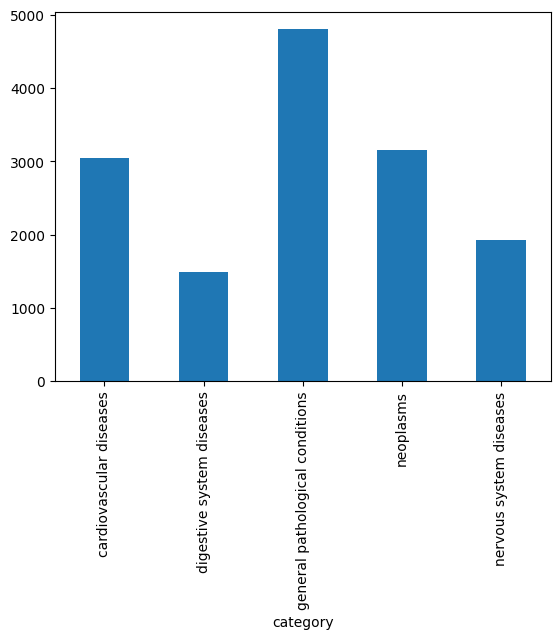

In [73]:
df = df.replace({"category": condition_dict})
df.groupby(['category']).size().plot.bar()

In [74]:
import torch
import numpy as np
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {
     "neoplasms" : 0,
     "digestive system diseases" : 1,
     "nervous system diseases" : 2,
     "cardiovascular diseases" : 3,
     "general pathological conditions" : 4
}

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['category']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [75]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

11550 1444 1444


In [76]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [77]:
from torch.optim import Adam
from tqdm import tqdm

def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  
EPOCHS = 5
model = BertClassifier()
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 5775/5775 [05:29<00:00, 17.55it/s]


Epochs: 1 | Train Loss:  0.705                 | Train Accuracy:  0.410                 | Val Loss:  0.609                 | Val Accuracy:  0.543


100%|██████████| 5775/5775 [05:29<00:00, 17.51it/s]


Epochs: 2 | Train Loss:  0.544                 | Train Accuracy:  0.579                 | Val Loss:  0.507                 | Val Accuracy:  0.591


100%|██████████| 5775/5775 [05:30<00:00, 17.50it/s]


Epochs: 3 | Train Loss:  0.460                 | Train Accuracy:  0.632                 | Val Loss:  0.474                 | Val Accuracy:  0.618


100%|██████████| 5775/5775 [05:29<00:00, 17.52it/s]


Epochs: 4 | Train Loss:  0.419                 | Train Accuracy:  0.662                 | Val Loss:  0.468                 | Val Accuracy:  0.605


100%|██████████| 5775/5775 [05:29<00:00, 17.52it/s]


Epochs: 5 | Train Loss:  0.387                 | Train Accuracy:  0.684                 | Val Loss:  0.474                 | Val Accuracy:  0.598


In [78]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    
evaluate(model, df_test)

Test Accuracy:  0.604


In [79]:
#Save Model

torch.save(model.state_dict(), 'med_rec_class_v1.pt')